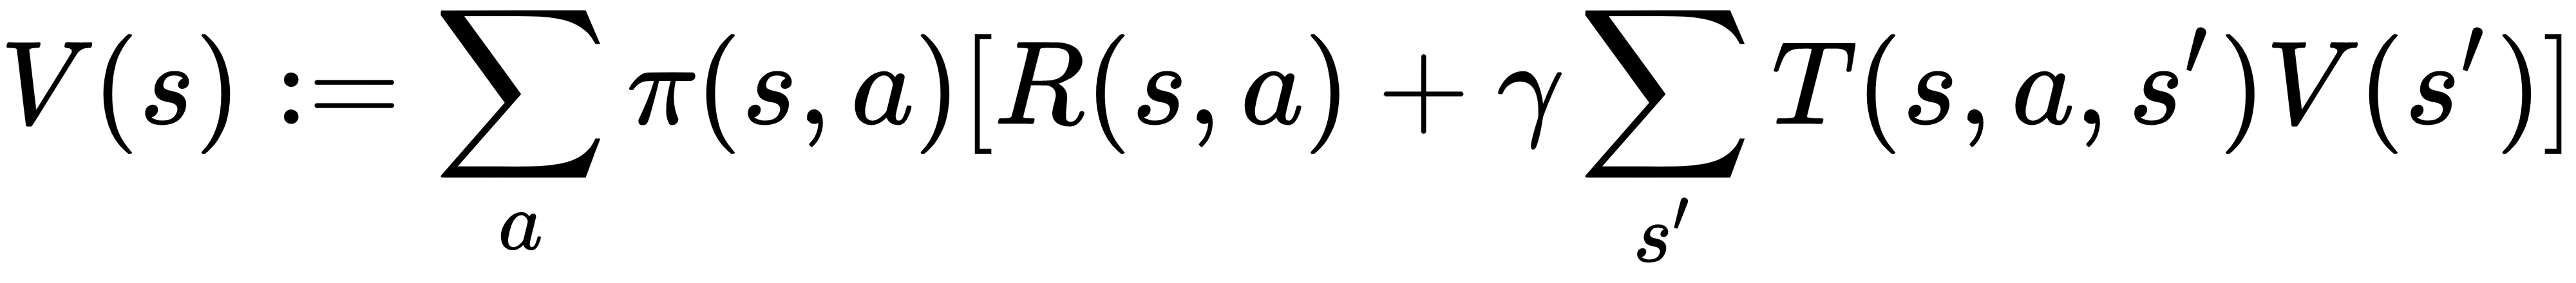

Previously, we took a sum over all the actions

Now

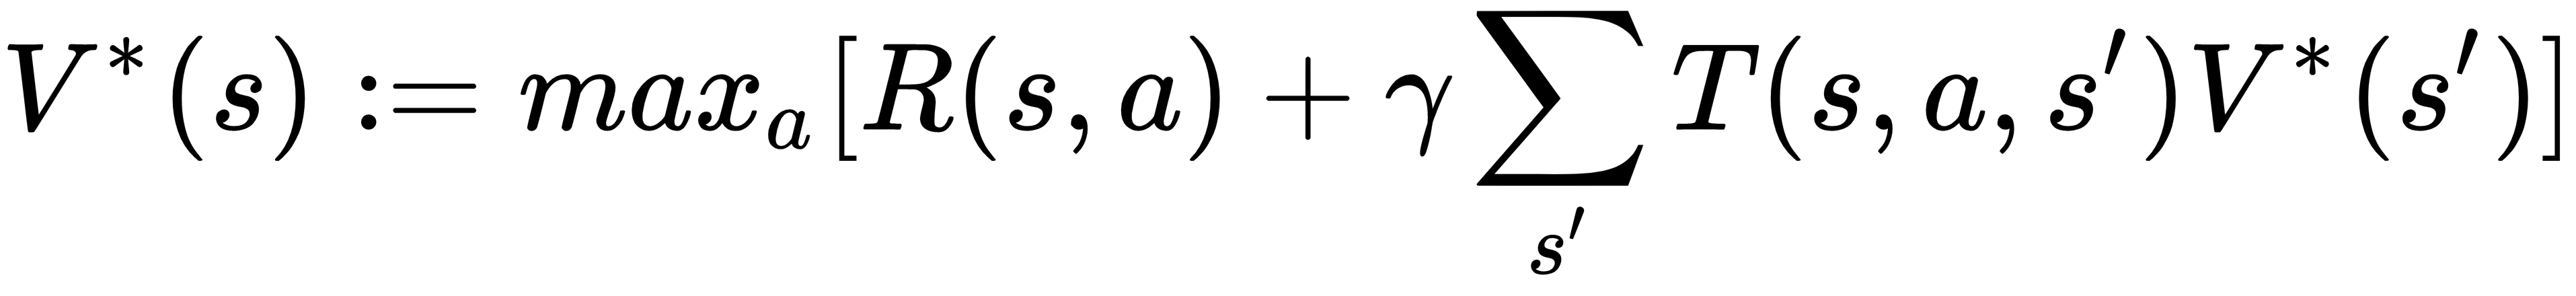

In [1]:
import torch
import gym
env = gym.make("FrozenLake-v1", render_mode="human")

In [2]:
gamma = 0.99
threshold = 0.0001

In [21]:
def value_iteration(env, gamma, threshold):
    """
    Solve a given environment with value iteration algorithm@param env: OpenAI Gym environment
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: values of the optimal policy for the given environment
    """
    n_state = env.observation_space.n # 8
    n_action = env.action_space.n # 4
    V = torch.zeros(n_state) # Value of each state
    i=0
    while True:
        V_temp = torch.empty(n_state)
        for state in range(n_state): # for each state, which action is best is learnt --> e.g. [2,1,0,0,3,2,1,3]
            v_actions = torch.zeros(n_action) # v_actions = tensor([0., 0., 0., 0.]) # initial scores of each action
            for action in range(n_action): # Pick one action, and calculate total score for that action
                for trans_prob, new_state, reward, _ in env.env.P[state][action]:  # If in state s, env.env.P has different states s' it can go to, using different actions --> e.g. [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False)]
                    # The system has these probs already defined, each state has a distribution of actions already, with their rewards, new_state, trans_prob
                    v_actions[action] += trans_prob * (reward + gamma * V[new_state]) # the value of the action depends on: 1. (s') new_state's value, 2. reward on taking that action, 3. trans_prob of reaching the new_state s' 
            V_temp[state] = torch.max(v_actions)  # v_actions has some values associated with each action, choose the one with maximum value
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        i+=1
        if max_delta <= threshold:
            print(f"Total iterations to converge: {i}")
            break
    return V

In [26]:
V_optimal = value_iteration(env, gamma, threshold)
print('Optimal values:\n{}'.format(V_optimal)) 
"""
Value of each state is measured by :
When in a state, any of the 4 actions can be taken, and the value of new state can be more for any of those 4 actions.
So the value of each state is the sum over each of those actions
1. each action a:
   Each action can lead to different states:
        A. So sum over the valuation of each of those states * trans_prob (prob of going to that state given action a)
        B. Reward: As each action can lead to different states, the rewards will be different. So sum over the rewards also. (Note the reward is dependent on the new state reached for taking action a from state s)
"""

Total iterations to converge: 172
Optimal values:
tensor([0.5404, 0.4966, 0.4681, 0.4541, 0.5569, 0.0000, 0.3572, 0.0000, 0.5905,
        0.6421, 0.6144, 0.0000, 0.0000, 0.7410, 0.8625, 0.0000])


'\nValue of each state is measured by :\nWhen in a state, any of the 4 actions can be taken, and the value of new state can be more for any of those 4 actions.\nSo the value of each state is the sum over each of those actions\n1. each action a:\n   Each action can lead to different states:\n        A. So sum over the valuation of each of those states * trans_prob (prob of going to that state given action a)\n        B. Reward: As each action can lead to different states, the rewards will be different. So sum over the rewards also. (Note the reward is dependent on the new state reached for taking action a from state s)\n'

In [27]:
def extract_optimal_policy(env, V_optimal, gamma):
    """
    Obtain the optimal policy based on the optimal values
    @param env: OpenAI Gym environment
    @param V_optimal: optimal values
    @param gamma: discount factor
    @return: optimal policy
    """
    n_state = env.observation_space.n # 8
    n_action = env.action_space.n # 4
    optimal_policy = torch.zeros(n_state) # Note that a policy is a distribution of actions [a1,a2,a3,a4] for each state: [[a1,a2,a3,a4], [a'1,a'2,a'3,a'4], ...] OR as in this case is: [max([a1,a2,a3,a4]), max([a'1,a'2,a'3,a'4]),...]
    for state in range(n_state):
        v_actions = torch.zeros(n_action) # v_actions = tensor([0., 0., 0., 0.])
        for action in range(n_action):
            for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                v_actions[action] += trans_prob * (reward + gamma * V_optimal[new_state]) # After you take the action, the value of the new state depends on pre-determined optimal value 
        optimal_policy[state] = torch.argmax(v_actions) # After you have the total value of all actions, choose the maximum action value 
    return optimal_policy

In [28]:
optimal_policy = extract_optimal_policy(env, V_optimal, gamma)
print('Optimal policy:\n{}'.format(optimal_policy))


Optimal policy:
tensor([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])


In [32]:
def run_episode(env, policy):
    state = env.reset()[0]
    total_reward = 0
    is_done = False
    while not is_done:
        action = policy[state].item()
        state, reward, is_done, trunc, info = env.step(int(action))
        total_reward += reward
        if is_done:
            break
    return total_reward

In [33]:
n_episode = 10
total_rewards = []
for episode in range(n_episode):
    total_reward = run_episode(env, optimal_policy)
    total_rewards.append(total_reward)
print('Average total reward under the optimal policy: {}'.format(sum(total_rewards) / n_episode))

Average total reward under the optimal policy: 0.7
